In [8]:
import pandas as pd
from fastai import *
from fastai.text.all import *

In [4]:
os.chdir("../../")

In [12]:
def get_news():
    df = pd.read_parquet("import/output/news.parquet")
    return df 

In [13]:
def get_dls_lm(df):
    df = df.astype(str)
    dls = TextDataLoaders.from_df(df, valid_pct = .1,
            text_col='content', is_lm=True, num_workers=4)
    return dls

In [14]:
def train_lm(dls_lm):
    learn = language_model_learner(dls_lm, AWD_LSTM, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()
    return learn

In [ ]:
news = get_news()
print(news.columns)
dls_lm = get_dls_lm(news)
learn_lm = train_lm(dls_lm)

In [8]:
dls_lm.show_batch(max_n=5)

,text,text_
0,"xxbos xxmaj the xxmaj louisiana xxmaj department of xxmaj health gave the go - ahead xxmaj wednesday for medical providers to start xxunk kids between the ages of 5 and 11 with the pfizer - biontech vaccine , clearing the way for a big chunk of xxmaj louisiana ’s population to gain protection against xxup covid-19 . xxmaj the sign - off from xxup ldh came after expert advisory panels from the","xxmaj the xxmaj louisiana xxmaj department of xxmaj health gave the go - ahead xxmaj wednesday for medical providers to start xxunk kids between the ages of 5 and 11 with the pfizer - biontech vaccine , clearing the way for a big chunk of xxmaj louisiana ’s population to gain protection against xxup covid-19 . xxmaj the sign - off from xxup ldh came after expert advisory panels from the xxmaj"
1,mix themselves . xxmaj shaken ? xxmaj stirred ? xxmaj how about xxmaj xxunk ? xxmaj there are a lot of great players playing a lot of great golf these days . xxmaj players such as current world xxmaj no . 1 xxmaj scottie xxmaj scheffler . xxmaj masters rookie and former xxup lsu star xxmaj sam xxmaj burns is xxmaj no . 2 on the fedex xxmaj cup points list .,themselves . xxmaj shaken ? xxmaj stirred ? xxmaj how about xxmaj xxunk ? xxmaj there are a lot of great players playing a lot of great golf these days . xxmaj players such as current world xxmaj no . 1 xxmaj scottie xxmaj scheffler . xxmaj masters rookie and former xxup lsu star xxmaj sam xxmaj burns is xxmaj no . 2 on the fedex xxmaj cup points list . xxmaj
2,"august 4 , 1987 , and was a lifelong area resident . xxmaj she enjoyed spending time with her family and friends . xxmaj survivors include her parents xxmaj adam and xxmaj ronnie xxmaj derouen xxmaj poirrier xxmaj jr . of xxmaj jeanerette ; son xxmaj aaron xxmaj carl xxmaj poirrier of xxmaj jeanerette ; sisters xxmaj rebecca xxup l. xxmaj broussard ( keith ) of xxmaj jeanerette and xxmaj xxunk xxmaj","4 , 1987 , and was a lifelong area resident . xxmaj she enjoyed spending time with her family and friends . xxmaj survivors include her parents xxmaj adam and xxmaj ronnie xxmaj derouen xxmaj poirrier xxmaj jr . of xxmaj jeanerette ; son xxmaj aaron xxmaj carl xxmaj poirrier of xxmaj jeanerette ; sisters xxmaj rebecca xxup l. xxmaj broussard ( keith ) of xxmaj jeanerette and xxmaj xxunk xxmaj kinchen"
3,"xxmaj the market at 2727 xxmaj jackson xxmaj street , xxmaj alexandria , saw a record attendance in 2021 and continues to grow . xxmaj in 2021 alone , over 14 , xxrep 3 0 people visited the market , buying fresh food and items from over 30 vendors . xxmaj it is open every xxmaj tuesday from 3 - 6 p.m. and is operated by xxmaj louisiana xxmaj central . xxmaj","the market at 2727 xxmaj jackson xxmaj street , xxmaj alexandria , saw a record attendance in 2021 and continues to grow . xxmaj in 2021 alone , over 14 , xxrep 3 0 people visited the market , buying fresh food and items from over 30 vendors . xxmaj it is open every xxmaj tuesday from 3 - 6 p.m. and is operated by xxmaj louisiana xxmaj central . xxmaj to"
4,"said . \n xxmaj if you have any information about xxmaj ella xxmaj goodie 's whereabouts , you 're encouraged to call xxmaj louisiana xxmaj state xxmaj police at ( 318 ) 484 - 2194 or submit a tip at lsp.org . xxbos xxup new xxup orleans — the xxmaj port of xxmaj new xxmaj orleans said it has been awarded a fifth round of grant funding to continue its award -",". \n xxmaj if you have any information about xxmaj ella xxmaj goodie 's whereabouts , you 're encouraged to call xxmaj louisiana xxmaj state xxmaj police at ( 318 ) 484 - 2194 or submit a tip at lsp.org . xxbos xxup new xxup orleans — the xxmaj port of xxmaj new xxmaj orleans said it has been awarded a fifth round of grant funding to continue its award - winning"


In [9]:
bs = 128
lr = 1e-2
lr *= bs/48

In [ ]:
learn_lm.fit_one_cycle(1, lr)

In [ ]:
learn_lm.lr_find()

In [ ]:
learn_lm.save("learnlm")

In [ ]:
learn_lm.load("learnlm")

In [ ]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(10, lr/10)

In [103]:
learn_lm.save('learnlm_ftuned')
learn_lm.save_encoder('learnlm_ftuned_enc')

In [37]:
### additional parameter will be introduced into the classifier model below after training of language model: text_vocab=learn_lm.vocab 

def get_dls_cm(train_df):
    dls_cm = TextDataLoaders.from_df(train_df, valid_pct = .2, text_col='content', is_lm=False, label_col='relevant', 
    shuffle=True, bs=128, seq_len=72, y_block=CategoryBlock)
    return dls_cm

In [ ]:
train_df = pd.read_parquet("import/output/train.parquet")

dls_cm = get_dls_cm(train_df)

In [39]:
dls_cm.show_batch(max_n=3)

,text,category
0,"xxbos xxmaj editor ’s xxmaj note : xxmaj this article was produced for propublica ’s xxmaj local xxmaj reporting xxmaj network in partnership with xxup wrfk and xxup wwno . \n xxmaj when sheriff ’s deputies in xxmaj jefferson xxmaj parish , xxmaj louisiana , pulled over xxmaj octavio xxmaj lopez for an expired inspection tag in 2018 , they wrote on his traffic ticket that he is white . xxmaj lopez , who is from xxmaj nicaragua , is xxmaj hispanic and speaks only xxmaj spanish , said his wife . \n xxmaj in fact , of the 167 tickets issued by deputies to drivers with the last name xxmaj lopez over a nearly six - year span , not one of the motorists was labeled as xxmaj hispanic , according to records provided by the xxmaj jefferson xxmaj parish clerk of court . xxmaj the same was true",1
1,"xxbos xxmaj editor ’s xxmaj note : xxmaj this article was produced for propublica ’s xxmaj local xxmaj reporting xxmaj network in partnership with xxup wrfk and xxup wwno . \n xxmaj when sheriff ’s deputies in xxmaj jefferson xxmaj parish , xxmaj louisiana , pulled over xxmaj octavio xxmaj lopez for an expired inspection tag in 2018 , they wrote on his traffic ticket that he is white . xxmaj lopez , who is from xxmaj nicaragua , is xxmaj hispanic and speaks only xxmaj spanish , said his wife . \n xxmaj in fact , of the 167 tickets issued by deputies to drivers with the last name xxmaj lopez over a nearly six - year span , not one of the motorists was labeled as xxmaj hispanic , according to records provided by the xxmaj jefferson xxmaj parish clerk of court . xxmaj the same was true",1
2,"xxbos xxmaj editor ’s xxmaj note : xxmaj this article was produced for propublica ’s xxmaj local xxmaj reporting xxmaj network in partnership with xxup wrfk and xxup wwno . \n xxmaj when sheriff ’s deputies in xxmaj jefferson xxmaj parish , xxmaj louisiana , pulled over xxmaj octavio xxmaj lopez for an expired inspection tag in 2018 , they wrote on his traffic ticket that he is white . xxmaj lopez , who is from xxmaj nicaragua , is xxmaj hispanic and speaks only xxmaj spanish , said his wife . \n xxmaj in fact , of the 167 tickets issued by deputies to drivers with the last name xxmaj lopez over a nearly six - year span , not one of the motorists was labeled as xxmaj hispanic , according to records provided by the xxmaj jefferson xxmaj parish clerk of court . xxmaj the same was true",1


In [40]:
model = text_classifier_learner(dls_cm, AWD_LSTM, drop_mult=.5, metrics=accuracy)

In [ ]:
model.load_encoder("learnlm_ftuned")

In [41]:
model.freeze()

In [47]:
bs = 128
lr = 2e-2
lr *= bs/128

In [ ]:
model.fit_one_cycle(10, lr)
# 70% acc with .2 valid, .5 drop, 128 bs, 2e-2 loss
# keep this training rate, but add epochs and see what happens. 
# (batch size increase from 64 to 128 increased accuracy by 10 points)


In [ ]:
model.lr_find()

In [ ]:
model.freeze_to(-3) 
model.fit_one_cycle(10, slice(1e-2/(2.6**4),1e-2))

In [ ]:
model.lr_find()

In [ ]:
model.freeze_to(-5) 
model.fit_one_cycle(5, slice(2e-2/(2.6**4),2e-2))

In [ ]:
model.unfreeze()
model.fit_one_cycle(3, slice(2e-3/(2.6**4),2e-3))

In [ ]:
model.save("model")

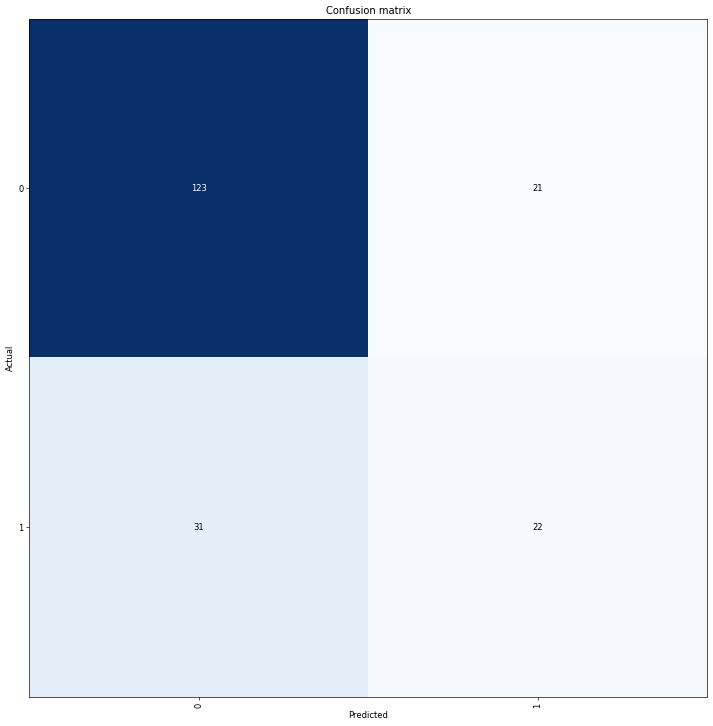

In [41]:
interp = ClassificationInterpretation.from_learner(learn_lm)

losses,idxs = interp.top_losses()

interp.plot_confusion_matrix(figsize=(12,12), dpi=60)